Atalov S.

# Transfer Learning
## MobileNetV2

---

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras import layers
import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

---
## 1. Create the Dataset and Split it into Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

If you're specifying a validation split, you'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

**You'll also set your seeds to match each other, so your training and validation sets don't overlap.**

In [4]:
# READ IMAGES
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
DIRECTORY = "dataset/"

train_dataset = image_dataset_from_directory(DIRECTORY,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DIRECTORY,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 362 files belonging to 2 classes.
Using 290 files for training.
Found 362 files belonging to 2 classes.
Using 72 files for validation.


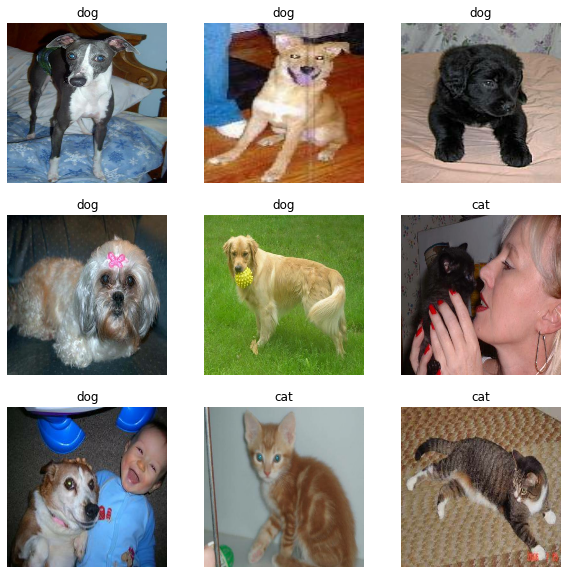

In [5]:
# Show images
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

---
## 2. Preprocess and Augment Training Data

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.

### Exercise 1 - data_augmenter

Implement a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [6]:
# Augmentation
def data_augmenter():data_augmentation = tf.keras.Sequential([
        RandomFlip('horizontal'),
        RandomRotation(0.2)
    ])
    return data_augmentation

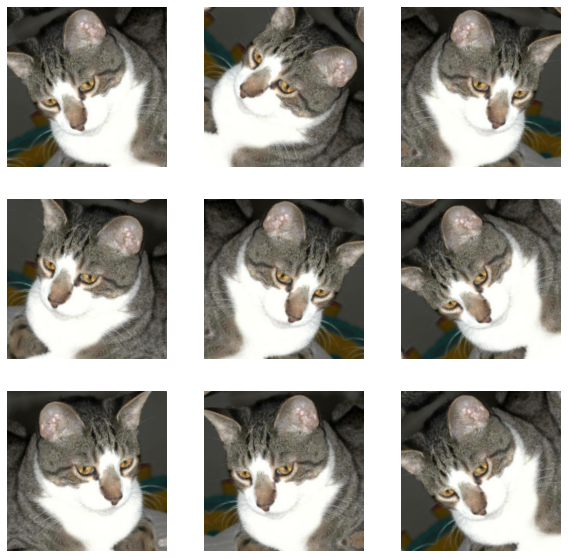

In [7]:
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

---
## 3. Using MobileNetV2 for Transfer Learning

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:
- Depthwise separable convolutions
- Thin input and output bottlenecks between layers
- Shortcut connections between bottleneck layers

In [8]:
IMG_SHAPE = (160, 160, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14536120/14536120 [==============================] - 5s 0us/step


In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

Note the last 4 layers here. The last two layers are the so called top layers, and they are responsible of the classification in the model

In [10]:
n_layers = len(base_model.layers)
print(base_model.layers[n_layers - 4].name)
print(base_model.layers[n_layers - 3].name)
print(base_model.layers[n_layers - 2].name)
print(base_model.layers[n_layers - 1].name)

Conv_1_bn
out_relu
global_average_pooling2d
predictions


### 3.1. Layer Freezing with the Functional API

<img src="https://assets-global.website-files.com/5f854ebf1a80ea53fd7df5da/6212e9ddfa664d7849e0618a_senior-dog-with-kitten_main.jpg" style="width:400px;height:250px;">

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to classify cats and dogs. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

### Exercise 2 - cat_dog_model

In [12]:
def cat_dog_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,) # to add 3 RGB color channels
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x)
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    
    ### !!! YOUR SOLUTION !!!
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [13]:
data_augmentation = data_augmenter()

In [14]:
model = cat_dog_model(IMG_SIZE, data_augmentation)

9406464/9406464 [==============================] - 3s 0us/step


#### How many Trainable params?

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [16]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


10/10 [==============================] - 14s 613ms/step - loss: 0.7160 - accuracy: 0.6207 - val_loss: 0.4405 - val_accuracy: 0.8472
Epoch 2/5
10/10 [==============================] - 5s 451ms/step - loss: 0.4239 - accuracy: 0.7931 - val_loss: 0.2892 - val_accuracy: 0.9028
Epoch 3/5
10/10 [==============================] - 5s 480ms/step - loss: 0.3721 - accuracy: 0.8586 - val_loss: 0.2196 - val_accuracy: 0.9306
Epoch 4/5
10/10 [==============================] - 5s 481ms/step - loss: 0.3047 - accuracy: 0.8690 - val_loss: 0.1785 - val_accuracy: 0.9444
Epoch 5/5
10/10 [==============================] - 5s 526ms/step - loss: 0.2265 - accuracy: 0.9310 - val_loss: 0.1550 - val_accuracy: 0.9444


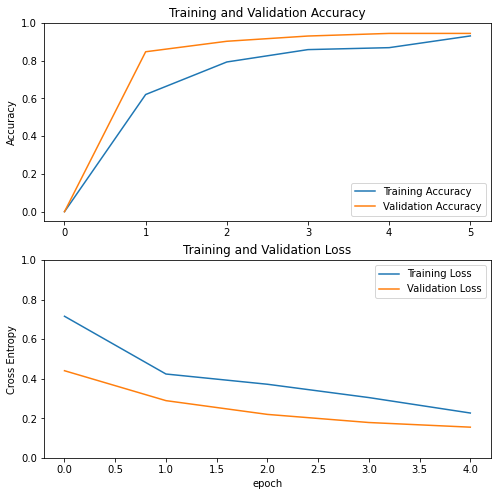

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 3.2. Fine-tuning the Model

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

In [19]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']



model.compile(loss=loss_function,
            optimizer = optimizer,
            metrics=metrics)

Number of layers in the base model:  156


In [20]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10


10/10 [==============================] - 14s 844ms/step - loss: 0.2157 - accuracy: 0.9310 - val_loss: 0.1519 - val_accuracy: 0.9444
Epoch 6/10
10/10 [==============================] - 16s 779ms/step - loss: 0.2285 - accuracy: 0.9172 - val_loss: 0.1495 - val_accuracy: 0.9444
Epoch 7/10
10/10 [==============================] - 11s 661ms/step - loss: 0.2191 - accuracy: 0.9310 - val_loss: 0.1474 - val_accuracy: 0.9444
Epoch 8/10
10/10 [==============================] - 6s 536ms/step - loss: 0.2382 - accuracy: 0.8897 - val_loss: 0.1442 - val_accuracy: 0.9444
Epoch 9/10
10/10 [==============================] - 6s 531ms/step - loss: 0.1972 - accuracy: 0.9414 - val_loss: 0.1419 - val_accuracy: 0.9444
Epoch 10/10
10/10 [==============================] - 5s 527ms/step - loss: 0.2006 - accuracy: 0.9241 - val_loss: 0.1398 - val_accuracy: 0.9444


In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

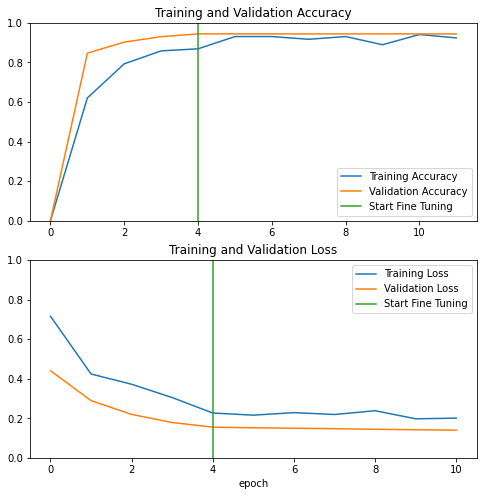

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

---
## 4. Test on own images

In [23]:
from PIL import Image

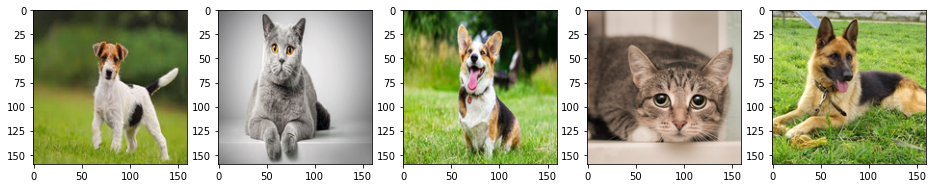

In [24]:
my_test_images = []

IMAGE_SIZE = (160, 160)
NUMBER_OF_IMAGES = 5

plt.figure(figsize=(16, 10))
for i in range(NUMBER_OF_IMAGES):
    # read file
    img = Image.open(f"./test_cat_dog/myimg{i}.jpg").resize(IMAGE_SIZE, Image.ANTIALIAS)
    img = np.array(img)
    
    my_test_images.append(img)
    ax = plt.subplot(1, NUMBER_OF_IMAGES, i + 1)
    plt.imshow(my_test_images[i])
    
my_test_images = np.array(my_test_images)

In [25]:
my_test_dataset = tf.data.Dataset.from_tensor_slices(my_test_images).batch(NUMBER_OF_IMAGES)

In [26]:
y_pred = np.round(model.predict(my_test_dataset), 0).flatten()

1/1 [==============================] - 1s 1s/step


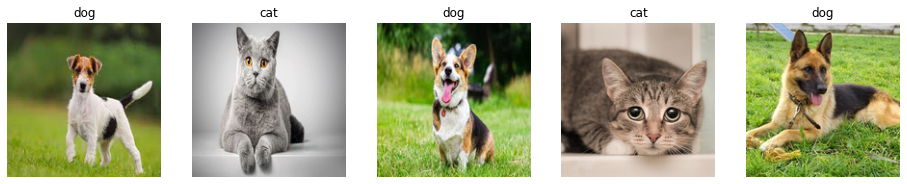

In [27]:
plt.figure(figsize=(16, 10))
for i in range(NUMBER_OF_IMAGES):
    ax = plt.subplot(1, NUMBER_OF_IMAGES, i + 1)
    plt.imshow(my_test_images[i])
    plt.title(class_names[int(y_pred[i])])
    plt.axis('off')

---
## 5. Homework

Collect the data ($\approx 100$ images) and train the model to classify one of the object pairs:
- keyboard vs mouse
- pencil vs notebook
- car vs truck
- apple vs watermelon 
- and etc

HINT: you can use web-scraping to collect the images (google)
[example](https://letmegooglethat.com/?q=keyboard)

In [80]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
DIRECTORY = "dataset/"

train_dataset = image_dataset_from_directory(DIRECTORY,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DIRECTORY,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  validation_split=0.2,
                                                  subset='validation',
                                                  seed=42)

Found 80 files belonging to 2 classes.
Using 64 files for training.
Found 80 files belonging to 2 classes.
Using 16 files for validation.


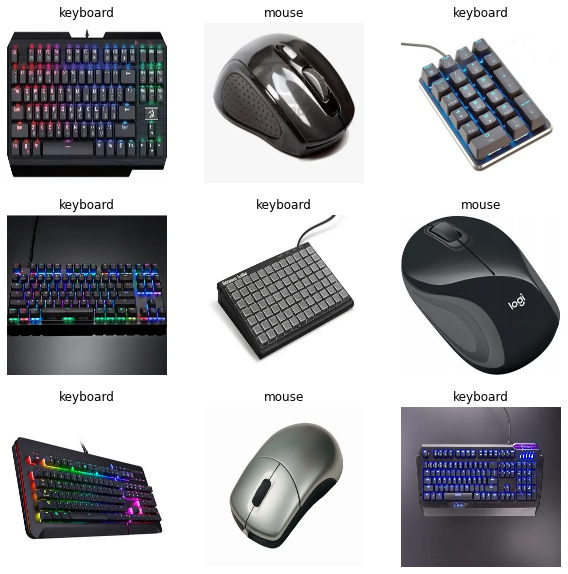

In [81]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

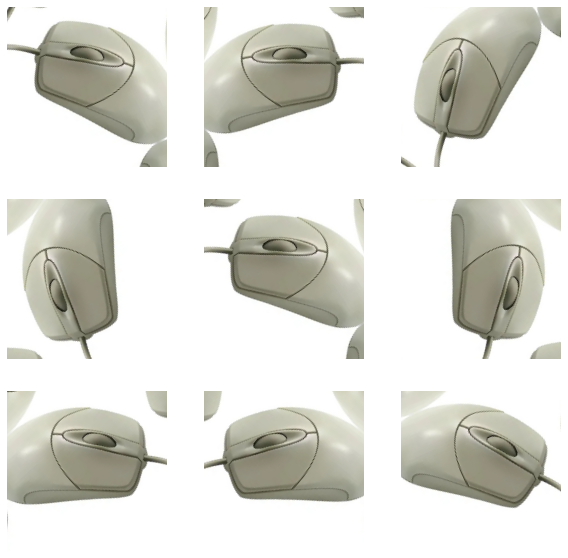

In [82]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [83]:
IMG_SHAPE = (160, 160, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [84]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [85]:
n_layers = len(base_model.layers)
print(base_model.layers[n_layers - 4].name)
print(base_model.layers[n_layers - 3].name)
print(base_model.layers[n_layers - 2].name)
print(base_model.layers[n_layers - 1].name)

Conv_1_bn
out_relu
global_average_pooling2d_2
predictions


In [86]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [87]:
data_augmentation = data_augmenter()

In [88]:
model = cat_dog_model(IMG_SIZE, data_augmentation)

In [89]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [90]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
initial_epochs = 5
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


2/2 [==============================] - 14s 3s/step - loss: 0.5173 - accuracy: 0.7344 - val_loss: 0.3780 - val_accuracy: 0.9375
Epoch 2/5
2/2 [==============================] - 2s 887ms/step - loss: 0.3318 - accuracy: 0.9062 - val_loss: 0.2969 - val_accuracy: 0.9375
Epoch 3/5
2/2 [==============================] - 2s 917ms/step - loss: 0.2707 - accuracy: 0.9219 - val_loss: 0.2349 - val_accuracy: 0.9375
Epoch 4/5
2/2 [==============================] - 1s 831ms/step - loss: 0.1929 - accuracy: 0.9688 - val_loss: 0.1888 - val_accuracy: 0.9375
Epoch 5/5
2/2 [==============================] - 2s 794ms/step - loss: 0.1392 - accuracy: 1.0000 - val_loss: 0.1526 - val_accuracy: 0.9375


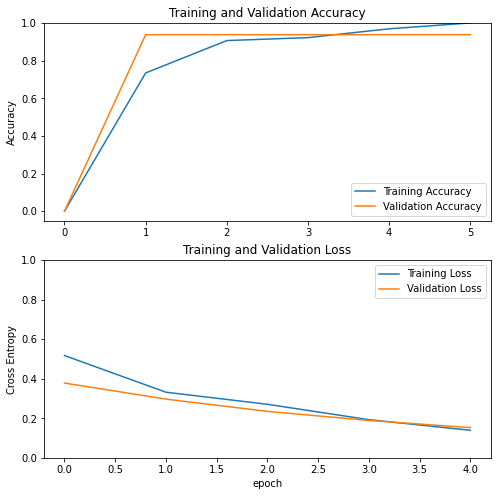

In [92]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [93]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

# Use accuracy as evaluation metric
metrics=['accuracy']



model.compile(loss=loss_function,
            optimizer = optimizer,
            metrics=metrics)

Number of layers in the base model:  156


In [94]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10


2/2 [==============================] - 14s 3s/step - loss: 0.1296 - accuracy: 1.0000 - val_loss: 0.1490 - val_accuracy: 0.9375
Epoch 6/10
2/2 [==============================] - 1s 853ms/step - loss: 0.1299 - accuracy: 0.9844 - val_loss: 0.1452 - val_accuracy: 0.9375
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.1113 - accuracy: 1.0000 - val_loss: 0.1419 - val_accuracy: 0.9375
Epoch 8/10
2/2 [==============================] - 2s 847ms/step - loss: 0.1076 - accuracy: 1.0000 - val_loss: 0.1386 - val_accuracy: 0.9375
Epoch 9/10
2/2 [==============================] - 2s 964ms/step - loss: 0.0990 - accuracy: 1.0000 - val_loss: 0.1354 - val_accuracy: 0.9375
Epoch 10/10
2/2 [==============================] - 2s 988ms/step - loss: 0.1057 - accuracy: 0.9844 - val_loss: 0.1322 - val_accuracy: 0.9375


In [95]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

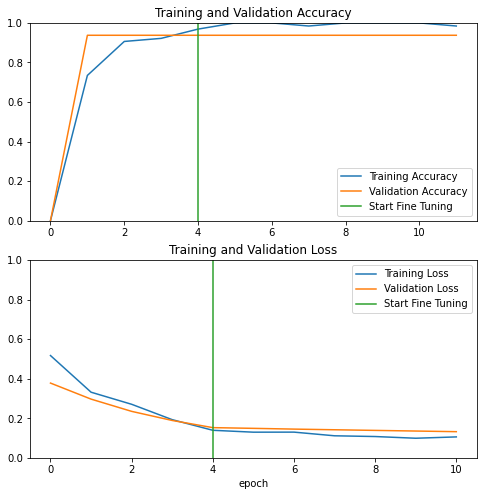

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

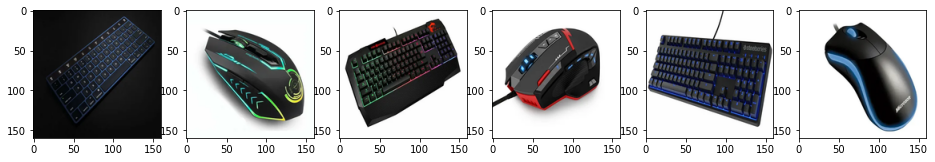

In [119]:
my_test_images = []

IMAGE_SIZE = (160, 160)
NUMBER_OF_IMAGES = 6

plt.figure(figsize=(16, 10))
for i in range(NUMBER_OF_IMAGES):
    img = Image.open(f"./test_mouse_keyboard/z{i + 1}.jpg").resize(IMAGE_SIZE, Image.ANTIALIAS)
    img = np.array(img)
    
    my_test_images.append(img)
    ax = plt.subplot(1, NUMBER_OF_IMAGES, i + 1)
    plt.imshow(my_test_images[i])
    
my_test_images = np.array(my_test_images)

In [120]:
my_test_dataset = tf.data.Dataset.from_tensor_slices(my_test_images).batch(NUMBER_OF_IMAGES)

In [121]:
y_pred = np.round(model.predict(my_test_dataset), 0).flatten()

1/1 [==============================] - 0s 132ms/step


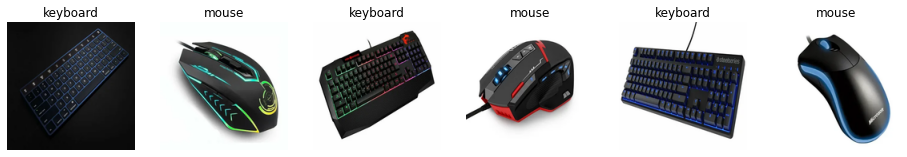

In [122]:
plt.figure(figsize=(16, 10))
for i in range(NUMBER_OF_IMAGES):
    ax = plt.subplot(1, NUMBER_OF_IMAGES, i + 1)
    plt.imshow(my_test_images[i])
    plt.title(class_names[int(y_pred[i])])
    plt.axis('off')